***WMC via Knowledge compilation***


---


1. Write a method that transforms a formula in sd-DNNF form, and use
this method for computing the weighted model count of propositional
formulas.

2. Check the correctness of your algorithm by comparing the results of
your method with the explicit computation of weighted model
counting via truth table.

3. Write a method that estimates #SAT using the sampleSat algorithm,
and compare the result of the approximated counting with the result
obtained by the exact counting.






In [1]:
#import libraries
from sympy import symbols, simplify, Not, And, Or, Implies, satisfiable, S, simplify, sympify
from sympy import symbols, And, Or, Not, Implies
from sympy.logic.boolalg import to_nnf, Boolean
from sympy.logic.inference import satisfiable
from sympy.logic.boolalg import to_cnf
from itertools import combinations
from functools import reduce
import random

Pipeline per convertire una formula F in sd-DNNF:

1. prendiamo una formula ***F***.
2. trasformo in ***NNF*** : formula in cui le negazioni compaiono solo davanti a preposizioni atomiche.
3. trasformo in ***DNNF*** (*Decomposable Negation Normal Form*) : è una NNF in cui ogni conjunction non ha proposizioni atomiche in comune, cioè `Φ₁ ∧ Φ₂` tale che `props(Φ₁) ∩ (Φ₂) = ∅` e per farlo applico Shannon's Expansion.
4. trasformo in ***d-DNNF*** (*Deterministic Decomposable Negation Normal Form*) : è una DNNF  in cui per ogni disjunction `Φ₁ v Φ₂ v .. v Φₙ` presenti nella formula stessa, c'è al massimo una i tale che `I |= Φᵢ`
Questo perchè i rami di un OR devono essere mutuamente esclusivi, altrimenti nel WMC rischiamo di contare due volte la stessa assegnazione di verità.
5. trasformo in ***sd-DNNF*** (*Smooth Deterministic Decomposable Negation Normal Form*) : applico smoothing left and right per garantire che tutti i disgiunti contengano tutte le variabili proposizionali - vedi regole di trasformazione (in sostanza viene usata una tautologia per le proposizioni atomiche mancanti)


Nota Bene: In realtà, il primissimo passo sarebbe la trasformazione di F in ***CNF***: è una formula in cui non compaiono i simboli di implicazione (→) o equivalenza (≡), ma nel nostro codice viene fatto dalla funzione to_nnf (importata).

In [2]:
# ============================================================
#  F -> NNF -> DNNF -> d-DNNF -> sd-DNNF (con Tau) -> WMC
#  (no normalize_formula: use directly to_nnf)
# ============================================================
# ---------------------------
# Boolean node Tau(v) for visible structural smoothing
# ---------------------------
class Tau(Boolean):
    """
    Represents the tautology (v ∨ ¬v) as an explicit node.
    In WMC, it contributes [w(v) + w(¬v)].
    """
    is_Tau = True

    def __new__(cls, v):
        v = sympify(v)
        obj = Boolean.__new__(cls)
        obj._v = v
        return obj

    @property
    def v(self):
        return self._v

    @property
    def args(self):
        return (self._v,)

    def _hashable_content(self):
        return (self._v,)

    @property
    def free_symbols(self):
        return {self._v}

def _tau(v):
    return Tau(v)

def _vars(e):
    return set(e.free_symbols)

# ---------------------------
# Shannon expansion (NO simplify)
# ---------------------------
def shannon_expansion(f, s):
    """
    f == (s ∧ f|s=True) ∨ (¬s ∧ f|s=False)
    """
    if s not in f.free_symbols:
        return f
    f1 = f.subs({s: S.true})
    f0 = f.subs({s: S.false})
    return Or(And(s, f1), And(Not(s), f0))

# ---------------------------
# Utilities: variable-connected components
# ---------------------------
def _var_components(conj):
    """
    Group the factors of an AND into variable-connected blocks.
    Different blocks do not share variables -> decomposable AND.
    """
    if isinstance(conj, And):
        factors = list(conj.args)
    else:
        factors = [conj]
    comps = []
    while factors:
        seed = factors.pop()
        group = [seed]
        vars_grp = set(seed.free_symbols)
        changed = True
        while changed:
            changed = False
            rest = []
            for f in factors:
                if vars_grp & set(f.free_symbols):
                    group.append(f)
                    vars_grp |= set(f.free_symbols)
                    changed = True
                else:
                    rest.append(f)
            factors = rest
        comps.append(group)
    return comps

# ---------------------------
# 1) NNF -> DNNF
# Function that takes a NNF and returns a DNNF.
# It applies Shannon's Expansion in order to ensure decomposability.
# Every conjunction does not have common atomic propositions, i.e. Φ₁ ∧ Φ₂ such that props(Φ₁) ∩ (Φ₂) = ∅.
# ---------------------------
def NNF2DNNF(nnf):

    #Take Boolean variables from the formula and put them in a list
    #nnf.free_symbols is a set of SymPy symbols that appear in the expression
    atoms = list(nnf.free_symbols)

    #base case: the formula has 0 or 1 variable
    if len(atoms) <= 1:
        return simplify(nnf)

    #I build groups that are “variable-connected”: if I have only one group → not decomposable ⇒ I apply Shannon
    if isinstance(nnf, And): #check if current node is conjunction
        # _var_components takes the factors of the AND (e.g., F1 ∧ F2 ∧ F3) and groups 
        # Them into blocks such that within each block the factors share variables. 
        # If different blocks do not share variables → they are candidates for a decomposable AND.
        # Example: (A∨B)∧(¬A∨C)∧(D∨E) produces groups = [[A∨B, ¬A∨C], [D∨E]].
        groups = _var_components(nnf)
        if len(groups) > 1:
            compiled = [
                NNF2DNNF(And(*g)) if len(g) > 1 else NNF2DNNF(g[0])
                for g in groups ]
            return simplify(And(*compiled))  # decomposable AND 
        else: # No possible decomposition -> force split with Shannon
            pivot = atoms[0]
            return NNF2DNNF(shannon_expansion(nnf, pivot))

    if isinstance(nnf, Or):
        kids = [NNF2DNNF(k) for k in nnf.args]
        return simplify(Or(*kids))          # determinism after
    
    # fallback
    pivot = atoms[0]
    return NNF2DNNF(shannon_expansion(nnf, pivot))

# ---------------------------
# 2) DNNF -> d-DNNF (determinism on OR)
# ---------------------------
def _make_or_deterministic(expr):
    """
    Makes Or(...) deterministic without infinite recursions.
    Strategy:
    - as long as there is a joinable pair of children,
    choose a pivot in the INTERSECTION of their variables (if empty, in the UNION),
    apply Shannon to the entire OR and restart. Iterative.
    """
    assert isinstance(expr, Or)
    # flatten + dedup
    args = list(Or(*expr.args).args)
    uniq = []
    for a in args:
        if a not in uniq:
            uniq.append(a)
    args = uniq
    cur = Or(*args)

    while True:
        n = len(args)
        changed = False

        for i in range(n):
            for j in range(i+1, n):
                if satisfiable(And(args[i], args[j])):  # overlap -> not deterministic
                    Vi, Vj = _vars(args[i]), _vars(args[j])
                    cand = list(Vi & Vj) or list(Vi | Vj)  # first intersection, then union
                    for p in cand:
                        new_or = shannon_expansion(Or(*args), p)
                        if new_or != cur:       # check structural progress
                            cur = new_or
                            args = list(cur.args) if isinstance(cur, Or) else [cur]
                            changed = True
                            break
                    break
            if changed:
                break
        if not changed:
            return cur

# ---------------------------
# 2) DNNF -> d-DNNF (determinism on OR)
# ---------------------------
def DNNF2dDNNF(dnnf):
    if isinstance(dnnf, And):
        return And(*(DNNF2dDNNF(a) for a in dnnf.args))
    if isinstance(dnnf, Or):
        kids = [DNNF2dDNNF(a) for a in dnnf.args]
        det = _make_or_deterministic(Or(*kids))
        if isinstance(det, Or):
            return Or(*(DNNF2dDNNF(a) for a in det.args))
        return det
    return dnnf  # literal / True / False

# ---------------------------
# 3) d-DNNF -> sd-DNNF (smoothing with Tau)
# ---------------------------
def ddnnf2sdNNF(ddnnf):
    if isinstance(ddnnf, And):
        return And(*(ddnnf2sdNNF(a) for a in ddnnf.args))
    if isinstance(ddnnf, Or):
        kids = [ddnnf2sdNNF(a) for a in ddnnf.args]
        allv = set().union(*(_vars(k) for k in kids))
        smoothed = []
        for k in kids:
            missing = allv - _vars(k)
            kk = k
            for v in missing:
                kk = And(kk, _tau(v))  # keep Tau(v) visible
            smoothed.append(kk)
        return Or(*smoothed)
    return ddnnf  # literal / True / False

# ---------------------------
# 4) WMC on sd-DNNF (weights to literals)
# ---------------------------
def model_counting_sdnnf(sdNNF_formula, weights):
    """
    Calculate WMC on sd-DNNF:
      - literal: weights[literal]
      - Tau(v):  weights[v] + weights[Not(v)]
      - AND:     products of children
      - OR:      sum of children
    """
    if sdNNF_formula is S.true:
        return 1.0
    if sdNNF_formula is S.false:
        return 0.0

    # literals (a, ~a, ...)
    if sdNNF_formula in weights:
        #print("sdNNF_formula, ", float(weights[sdNNF_formula]))
        return float(weights[sdNNF_formula])

    # Tau(v) inserted from smoothing
    if isinstance(sdNNF_formula, Tau):
        v = sdNNF_formula.v
        return float(weights[v] + weights[Not(v)])

    # AND: product
    if isinstance(sdNNF_formula, And):
        val = 1.0
        for ch in sdNNF_formula.args:
            val *= model_counting_sdnnf(ch, weights)
        return val

    # OR: sum
    if isinstance(sdNNF_formula, Or):
        return sum(model_counting_sdnnf(ch, weights) for ch in sdNNF_formula.args)

    raise ValueError(f"Unmanaged node: {sdNNF_formula}")

# ---------------------------
# 5) Orchestrator End-to-end: F -> sd-DNNF
# ---------------------------
def compile_to_sdDNNF(F):
    """
    F -> NNF -> DNNF -> d-DNNF -> sd-DNNF
    (no final simplify to avoid losing the Tau nodes)
    """
    # removes ⇒, ↔ e force NOT to literals
    F_nnf  = to_nnf(F, simplify=True)   

    F_dnnf = NNF2DNNF(F_nnf)
    F_dd   = DNNF2dDNNF(F_dnnf)
    F_sdd  = ddnnf2sdNNF(F_dd)
    return F_sdd

For other test cases -> modify the formula and weights section

In [3]:
# ==============================================================
# SampleSAT and comparison with estimate #SAT vs #SAT via sd-DNNF
# ==============================================================



# --- utilities ---
def _vars_set(F):
    if "_vars" in globals() and callable(_vars):
        return set(_vars(F))
    return set(F.free_symbols)

def _eval_under(F, assign):
    return bool(F.subs(assign))

def _random_assignment(V, rng=None):
    rng = rng or random
    return {v: bool(rng.getrandbits(1)) for v in V}

def _cnf_clauses(F):
    cnf = to_cnf(F, simplify=True)
    if cnf == True:
        return []
    if cnf == False:
        return [[]]
    if isinstance(cnf, Or):
        return [[arg for arg in cnf.args]]
    if isinstance(cnf, And):
        clauses = []
        for c in cnf.args:
            if isinstance(c, Or):
                clauses.append(list(c.args))
            else:
                clauses.append([c])
        return clauses
    return [[cnf]]

def _lit_is_true(lit, assign):
    if isinstance(lit, Not):
        v = lit.args[0]
        return assign.get(v, False) is False
    else:
        v = lit
        return assign.get(v, False) is True

def _unsat_clauses(clauses, assign):
    return [cl for cl in clauses if not any(_lit_is_true(l, assign) for l in cl)]

def _flip(var, assign):
    assign[var] = not assign[var]

def _num_unsat(clauses, assign):
    return sum(1 for cl in clauses if not any(_lit_is_true(l, assign) for l in cl))

# --- SampleSAT ---
def sample_sat(F, max_tries=50, max_flips=1000, noise=0.5, rng=None):
    rng = rng or random
    V = _vars_set(F)
    clauses = _cnf_clauses(F)

    if clauses == []:  # tautology
        return True, _random_assignment(V, rng)
    if clauses == [[]]:  # contradiction
        return False, {}

    for _ in range(max_tries):
        A = _random_assignment(V, rng)
        for _ in range(max_flips):
            if _eval_under(F, A):
                return True, dict(A)

            unsat = _unsat_clauses(clauses, A)
            if not unsat:
                return True, dict(A)
            cl = rng.choice(unsat)

            candidate_vars = []
            for lit in cl:
                v = lit.args[0] if isinstance(lit, Not) else lit
                candidate_vars.append(v)

            if rng.random() < noise:
                v_star = rng.choice(candidate_vars)
            else:
                best_v, best_score = None, None
                for v in set(candidate_vars):
                    _flip(v, A)
                    score = _num_unsat(clauses, A)
                    _flip(v, A)
                    if best_score is None or score < best_score:
                        best_score, best_v = score, v
                v_star = best_v if best_v is not None else rng.choice(candidate_vars)

            _flip(v_star, A)

    return False, {}

# --- Estimate #SAT ---
def estimate_sat_count_samplesat(F, runs=200, **samplesat_kwargs):
    V = _vars_set(F)
    n = len(V)
    success = 0
    for _ in range(runs):
        ok, _A = sample_sat(F, **samplesat_kwargs)
        if ok:
            success += 1
    p_hat = success / runs if runs else 0.0
    return p_hat * (2 ** n), {"p_hat": p_hat, "n": n, "success": success, "runs": runs}

# --- Exact counting via sd-DNNF ---
def exact_count_sdnnf(F):
    sd = compile_to_sdDNNF(F)
    V = _vars_set(F)
    weights = {}
    for v in V:
        weights[v] = 1.0
        weights[Not(v)] = 1.0
    return model_counting_sdnnf(sd, weights)

# --- Comparison ---
def compare_exact_vs_samplesat(F, runs=500, max_tries=50, max_flips=1000, noise=0.5):
    est, stats = estimate_sat_count_samplesat(
        F, runs=runs, max_tries=max_tries, max_flips=max_flips, noise=noise
    )
    exact = exact_count_sdnnf(F)
    rel_err = abs(est - exact) / exact if exact != 0 else (0.0 if est == 0 else float("inf"))
    return {
        "exact_count": int(exact),
        "estimated_count": float(est),
        "relative_error": float(rel_err),
        **stats
    }

# --- Example ---
A,B,C,D = symbols("A B C D")

#formule = [
#    ("(A or B) and C", And(Or(A, B), C)),
#    ("(A -> B) and (B or C)", And(Or(Not(A), B), Or(B, C))),
#    ("(A xor B) and (C or D)", And(Or(And(A, Not(B)), And(Not(A), B)), Or(C, D))),
#]

# Formula: (a & b) | (c & ¬a)
#a, b, c = symbols('a b c')
#F1 = Or(And(a, b), And(c, Not(a)))

# Formula: (A ∨ B) → (B ∨ C)



# DEMO

In [4]:
# ===========================
# TEST CASE 1 (Example 7.5 dispensa - result = 136)
# ===========================

# Formula: (a & b) | (c & ¬a)
a, b, c = symbols('a b c')
F1 = Or(And(a, b), And(c, Not(a)))
print("Formula:", F1)

# Weights
weights = {
    a: 2,   Not(a): 1,
    b: 5,   Not(b): 3,
    c: 7,   Not(c): 1
}

# Orchestration till sd-DNNF
F1_sdd = compile_to_sdDNNF(F1)
print("\nsd-DNNF:", F1_sdd)

# WMC calculation with actual weights
wmc_val = model_counting_sdnnf(F1_sdd, weights)
print("\nWMC:", wmc_val)

Formula: (a & b) | (c & ~a)

sd-DNNF: (a & b & Tau(c)) | (c & ~a & Tau(b))

WMC: 136.0


In [5]:
# ===========================
# TEST CASE 2 — (Exercise 119 dispensa - result = 23)
# ===========================

# Formula: (A ∨ B) → (B ∨ C)
A, B, C = symbols('A B C')
F2 = Implies(Or(A, B), Or(B, C))
print("Formula F2:", F2)

# Literals Weights (from screenshot)
weights = {
    A: 1,  Not(A): 2,
    B: 1,  Not(B): 2,
    C: 1,  Not(C): 2,
}

# Compilazione e WMC
F2_sdd = compile_to_sdDNNF(F2)
print("\nsd-DNNF:", F2_sdd)

W = model_counting_sdnnf(F2_sdd, weights)
print("WMC(F):", W)

Formula F2: Implies(A | B, B | C)

sd-DNNF: (C & Tau(A) & Tau(B)) | (~C & ((B & Tau(A)) | (~A & ~B)))
WMC(F): 23.0


In [6]:
# ===========================
# DEMO: comparison exact counting vs SampleSAT
# ===========================
A, B, C = symbols('A B C')
F2 = Implies(Or(A, B), Or(B, C))

formule = [
    ("(A and B) or (C and not a)", Or(And(a, b), And(c, Not(a)))),
    ("(A ∨ B) → (B ∨ C)", Implies(Or(A, B), Or(B, C))),
    #("(A xor B) and (C or D)", And(Or(And(A, Not(B)), And(Not(A), B)), Or(C, D))),
]

import pandas as pd
risultati = []
for nome, F in formule:
    res = compare_exact_vs_samplesat(F, runs=400, max_tries=60, max_flips=500, noise=0.5)
    risultati.append({"formula": nome, **res})

pd.DataFrame(risultati)

,formula,exact_count,estimated_count,relative_error,p_hat,n,success,runs
0,(A and B) or (C and not a),4,8.0,1.000000,1.0,3,400,400
1,(A ∨ B) → (B ∨ C),7,8.0,0.142857,1.0,3,400,400


In [7]:

# 1) Box riepilogativo (HTML) — modifica liberamente il contenuto del box
from IPython.display import display, HTML

def display_summary_box(title: str, items: dict):
    rows = "".join([f"<li><b>{k}</b>: {v}</li>" for k, v in items.items()])
    html = f"""
    <div style="border:2px solid #4CAF50; border-radius:12px; padding:16px; margin:10px 0;
                background:#f9fff9; font-family:Arial, sans-serif; font-size:14px;">
        ✅ <b>{title}</b>
        <ul style="margin-top:8px">{rows}</ul>
    </div>
    """
    display(HTML(html))

# Esempio d'uso
display_summary_box("Best Model: Random Forest", {
    "Accuracy": "92%",
    "F1-score": "90%",
    "Note": "Validazione 5-fold; iperparametri di default"
})



# 📌 Summary Outputs (Ready-to-Use)

Questa sezione contiene alcune **celle pronte** per produrre output riassuntivi e gradevoli nel notebook:
1) **Box riepilogativi** (HTML) per evidenziare risultati chiave  
2) **Funzione `show_summary`** riutilizzabile per metriche/modelli  
3) **Tabella riassuntiva** (pandas DataFrame) con stile chiaro  
4) **Grafico semplice** (matplotlib) per confronto immediato  

> Puoi copiare/riusare queste celle dove preferisci nel notebook.


In [8]:

# 2) Funzione riutilizzabile per un riepilogo compatto di metriche
from IPython.display import display, HTML

def show_summary(model_name: str, metrics: dict):
    # metrics attese: {'accuracy': float, 'precision': float, 'recall': float, 'f1': float}
    def fmt(v): 
        try:
            return f"{float(v):.2%}"
        except Exception:
            return str(v)

    html = f"""
    <div style="border:1px solid #ddd; border-radius:12px; padding:12px; margin:8px 0;
                background:#f7f9fc; font-family:Arial, sans-serif;">
        <h4 style="margin:0 0 8px 0;">📌 {model_name}</h4>
        <ul style="margin:0 0 0 18px;">
            <li>Accuracy: {fmt(metrics.get('accuracy', 'n/a'))}</li>
            <li>Precision: {fmt(metrics.get('precision', 'n/a'))}</li>
            <li>Recall: {fmt(metrics.get('recall', 'n/a'))}</li>
            <li>F1-score: {fmt(metrics.get('f1', 'n/a'))}</li>
        </ul>
    </div>
    """
    display(HTML(html))

# Esempio d'uso
show_summary("Random Forest", {"accuracy":0.92, "precision":0.89, "recall":0.91, "f1":0.90})


In [9]:

# 3) Tabella riassuntiva con stile (pandas)
import pandas as pd

summary_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score"],
    "Value":  [0.92, 0.89, 0.91, 0.90]
})

# Visualizzazione pulita: puoi modificare caption e formato a piacere.
styled = (summary_df.style
          .set_caption("📊 Summary of Model Performance")
          .format({"Value": "{:.2%}"})
          .hide(axis="index"))

styled


Metric,Value
Accuracy,92.00%
Precision,89.00%
Recall,91.00%
F1-score,90.00%


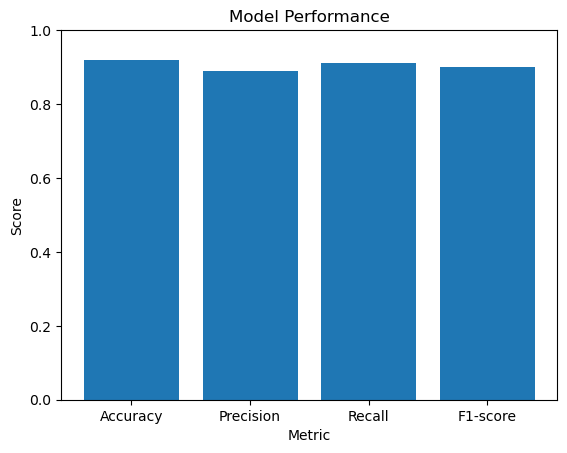

In [10]:

# 4) Grafico semplice (matplotlib) — bar chart per confronto rapido
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
values = [0.92, 0.89, 0.91, 0.90]

plt.figure()
plt.bar(metrics, values)   # nessun colore specificato
plt.ylim(0, 1)
plt.title("Model Performance")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.show()
